<h1 align=center><font size = 5>Opening Middle Eastern restaurant in Queens</font></h1>

## Introduction

This project will use the data in New York City json to extract information about Queens neighborhoods. It will also use the Foursquare API to explore Queens neighborhoods. Find the most common restaurant types in each neighborhood. Find the neighborhoods with most Middle Eastern restaurants and then use this feature to group the neighborhoods into clusters. Silouette clustering algorithm to complete this task. Also, the Folium library and Matplotlib to visualize most of this information.


## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1.  <a href="#item1">Download and Explore Dataset</a>

2.  <a href="#item2">Explore Queens Neighborhoods</a>

3.  <a href="#item3">Analyze Each Neighborhood</a>

4.  <a href="#item4">Cluster Neighborhoods</a>

5.  <a href="#item5">Examine Clusters</a>  
    </font>
    </div>


Before we get the data and start exploring it, let's download all the dependencies that we will need.


In [1]:
pip install folium # map rendering library

     |████████████████████████████████| 94 kB 5.8 MB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>


## 1. Download and Explore Dataset


In order to segment the neighborhoods of Queens and explore them, we will essentially need a dataset that contains NYC boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 


In [3]:
!wget -q -O 'newyork_data.json'  https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


#### Load and explore the data


Next, let's load the data.


In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Notice how all the relevant data is in the _features_ key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.


In [5]:
neighborhoods_data = newyork_data['features']

#### Tranform the data into a _pandas_ dataframe


The next task is essentially transforming this data of nested Python dictionaries into a _pandas_ dataframe. So let's start by creating an empty dataframe.


In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Then let's loop through the data and fill the dataframe one row at a time.


In [7]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine a sample of the resulting dataframe.


In [8]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


And make sure that the dataset has all 5 boroughs and 306 neighborhoods in NYC.


In [9]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.


In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.


In [10]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.


In [11]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='purple',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

However, for illustration purposes, let's simplify the above map and segment and cluster only the neighborhoods in Queens. So let's slice the original dataframe and create a new dataframe of the Queens data.


In [12]:
queens_data = neighborhoods[neighborhoods['Borough'] == 'Queens'].reset_index(drop=True)
print(queens_data.shape)
queens_data

(81, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Queens,Astoria,40.768509,-73.915654
1,Queens,Woodside,40.746349,-73.901842
2,Queens,Jackson Heights,40.751981,-73.882821
3,Queens,Elmhurst,40.744049,-73.881656
4,Queens,Howard Beach,40.654225,-73.838138
5,Queens,Corona,40.742382,-73.856825
6,Queens,Forest Hills,40.725264,-73.844475
7,Queens,Kew Gardens,40.705179,-73.829819
8,Queens,Richmond Hill,40.697947,-73.831833
9,Queens,Flushing,40.764454,-73.831773


Let's get the geographical coordinates of Queens.


In [13]:
address = 'Queens, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Queens are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Queens are 40.7498243, -73.7976337.


As we did with all of New York City, let's visualize Queens the neighborhoods in it.


In [14]:
# create map of Queens using latitude and longitude values
map_queens = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(queens_data['Latitude'], queens_data['Longitude'], queens_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_queens)  
    
map_queens

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.


#### Define Foursquare Credentials and Version


In [15]:
# The code was removed by Watson Studio for sharing.

<a id='item2'></a>


## 2. Explore Queens Neighborhoods


#### Let's create a function using Foursquare to get all restaurants in all the neighborhoods in Queens


In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    FOOD_CATEGORY = '4d4b7105d754a06374d81259'
    search_query = 'restaurant'        
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            search_query)
        #print(url)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called _queens_venues_ containing all Queens restaurants


In [17]:
queens_venues = getNearbyVenues(names=queens_data['Neighborhood'],
                                   latitudes=queens_data['Latitude'],
                                   longitudes=queens_data['Longitude']
                                  )

#### Let's check how many restaurants are in Queens


In [18]:
print('Queens has ' + str(queens_venues.size) + ' restaurants.\n Let\'s explore a sample of them' )
queens_venues.head(20)

Queens has 11291 restaurants.
 Let's explore a sample of them


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Astoria,40.768509,-73.915654,Favela Grill,40.767348,-73.917897,Brazilian Restaurant
1,Astoria,40.768509,-73.915654,Off The Hook,40.767200,-73.918104,Seafood Restaurant
2,Astoria,40.768509,-73.915654,Al-sham Sweets and Pastries,40.768077,-73.911561,Middle Eastern Restaurant
3,Astoria,40.768509,-73.915654,Sabry's,40.768446,-73.911267,Seafood Restaurant
4,Astoria,40.768509,-73.915654,Duzan,40.768730,-73.911013,Falafel Restaurant
5,Astoria,40.768509,-73.915654,Zyara Restaurant,40.766591,-73.912713,Restaurant
6,Astoria,40.768509,-73.915654,AbuQir Seafood,40.768577,-73.911169,Seafood Restaurant
7,Astoria,40.768509,-73.915654,Leli's Bakery and Pastry Shop,40.765132,-73.917696,Bakery
8,Astoria,40.768509,-73.915654,Brooklyn Bagel & Coffee Co.,40.764732,-73.916944,Bagel Shop
9,Astoria,40.768509,-73.915654,The Gully,40.766719,-73.912410,Indian Restaurant


#### Show the top Queens neighborhoods sorted by restaurants count in tabular and map format

In [19]:
queens_restaurants = queens_venues
queens_restaurants_count = queens_venues.groupby('Neighborhood').count()
queens_restaurants_count.reset_index(level=0, inplace=True)
queens_restaurants_count = queens_restaurants_count[['Neighborhood', 'Neighborhood Latitude']]
queens_restaurants_count.columns =['Neighborhood', 'Restaurants Count']
queens_restaurants_count = queens_restaurants_count.join(queens_data.dropna().set_index('Neighborhood'), on='Neighborhood')
queens_restaurants_count = queens_restaurants_count.sort_values(by=['Restaurants Count'], ascending=False)
queens_restaurants_count[['Neighborhood', 'Restaurants Count']].set_index('Neighborhood')

,Restaurants Count
Neighborhood,
Astoria,89
Sunnyside Gardens,75
Flushing,70
Woodside,64
Jackson Heights,58
Bayside,57
Long Island City,53
Sunnyside,46
Rego Park,45


In [20]:
# create map of Queens using latitude and longitude values
map_queens = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label,radius in zip(queens_restaurants_count['Latitude'], queens_restaurants_count['Longitude'], queens_restaurants_count['Neighborhood'], queens_restaurants_count['Restaurants Count']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=int(radius)/3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_queens)  
    
map_queens

#### Let's find out how many unique categories can be curated from all the returned restaurants


In [21]:
print('There are {} uniques restaurant types in Queens.'.format(len(queens_venues['Venue Category'].unique())))

There are 98 uniques restaurant types in Queens.


<a id='item3'></a>


## 3. Analyze Each Neighborhood


In [22]:
# one hot encoding
queens_onehot = pd.get_dummies(queens_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
queens_onehot['Neighborhood'] = queens_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [queens_onehot.columns[-1]] + list(queens_onehot.columns[:-1])
queens_onehot = queens_onehot[fixed_columns]

queens_onehot.head(100)

,Neighborhood,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Himalayan Restaurant,Hot Dog Joint,Hotpot Restaurant,Hunan Restaurant,Indian Restaurant,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Poke Place,Polish Restaurant,Ramen Restaurant,Restaurant,Romanian Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Astoria,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Astoria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Astoria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Astoria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Astoria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Astoria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Astoria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Astoria,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Astoria,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Astoria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.


In [23]:
queens_onehot.shape

(1613, 99)

#### Next, let's group rows by neighborhood and getting the number of restaurants in this neighborhood of each type


In [24]:
queens_grouped = queens_onehot.groupby('Neighborhood').sum().reset_index()
queens_grouped

,Neighborhood,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Himalayan Restaurant,Hot Dog Joint,Hotpot Restaurant,Hunan Restaurant,Indian Restaurant,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Poke Place,Polish Restaurant,Ramen Restaurant,Restaurant,Romanian Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Arverne,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,Astoria,0,0,0,0,0,1,3,5,0,1,1,0,1,0,0,5,1,0,0,3,0,1,0,6,0,1,0,0,0,1,0,1,1,0,0,1,0,0,4,0,0,0,0,0,6,1,0,0,0,0,5,0,1,2,0,2,1,0,1,0,4,2,9,1,1,0,0,0,0,0,5,1,0,0,1,0,0,1,4,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0
2,Astoria Heights,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Auburndale,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Bay Terrace,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,Bayside,0,2,0,0,1,0,1,1,1,0,0,0,2,0,0,2,1,0,0,4,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,3,0,0,0,0,0,4,0,0,2,0,0,2,0,1,0,2,3,0,0,0,1,0,0,0,0,4,0,0,0,2,0,0,0,1,0,1,0,1,0,0,1,2,3,0,0,0,0,1,0,0,0,1,0
6,Beechhurst,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Bellaire,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Belle Harbor,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Bellerose,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,4,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##### Displaying the top 10 restaurant types In each neighborhood according to the Top types

In [25]:
num_top_venues = 10
for neighborhood in queens_grouped['Neighborhood']:
    print("----"+neighborhood+"----")
    temp = queens_grouped[queens_grouped['Neighborhood'] == neighborhood].T.reset_index()
    temp.columns = ['Restaurant type','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arverne----
           Restaurant type  freq
0               Donut Shop   1.0
1                BBQ Joint   1.0
2              Pizza Place   1.0
3          Thai Restaurant   1.0
4            Burrito Place   1.0
5               Restaurant   1.0
6                     Café   1.0
7        Afghan Restaurant   0.0
8  New American Restaurant   0.0
9        Polish Restaurant   0.0


----Astoria----
             Restaurant type  freq
0  Middle Eastern Restaurant   9.0
1              Deli / Bodega   6.0
2           Greek Restaurant   6.0
3                     Bakery   5.0
4                       Café   5.0
5          Indian Restaurant   5.0
6                Pizza Place   5.0
7   Mediterranean Restaurant   4.0
8         Seafood Restaurant   4.0
9                 Food Truck   4.0


----Astoria Heights----
      Restaurant type  freq
0  Italian Restaurant   2.0
1       Deli / Bodega   2.0
2  Chinese Restaurant   2.0
3         Pizza Place   1.0
4              Bakery   1.0
5                Food   

In [26]:
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common restaurant type'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common restaurant type'.format(ind+1))

In [27]:
# Function: Sorting restaurant in Descending order
def return_most_common_restaurants(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [28]:
# create a new dataframe
q_neigh_restaurants_sorted = pd.DataFrame(columns=columns)
q_neigh_restaurants_sorted['Neighborhood'] = queens_grouped['Neighborhood']

for ind in np.arange(queens_grouped.shape[0]):
    q_neigh_restaurants_sorted.iloc[ind, 1:] = return_most_common_restaurants(queens_grouped.iloc[ind, :], num_top_venues)

In [29]:
q_neigh_restaurants_sorted.head(25)

,Neighborhood,1st Most Common restaurant type,2nd Most Common restaurant type,3rd Most Common restaurant type,4th Most Common restaurant type,5th Most Common restaurant type,6th Most Common restaurant type,7th Most Common restaurant type,8th Most Common restaurant type,9th Most Common restaurant type,10th Most Common restaurant type
0,Arverne,Pizza Place,Burrito Place,Donut Shop,Thai Restaurant,Restaurant,BBQ Joint,Café,Diner,Dosa Place,Dumpling Restaurant
1,Astoria,Middle Eastern Restaurant,Deli / Bodega,Greek Restaurant,Café,Bakery,Indian Restaurant,Pizza Place,Mediterranean Restaurant,Seafood Restaurant,Food Truck
2,Astoria Heights,Deli / Bodega,Italian Restaurant,Chinese Restaurant,Burger Joint,Food,Bakery,Pizza Place,Dosa Place,Dumpling Restaurant,Eastern European Restaurant
3,Auburndale,Deli / Bodega,American Restaurant,Italian Restaurant,Korean Restaurant,Noodle House,Sushi Restaurant,Food Truck,Fast Food Restaurant,Fish & Chips Shop,Dosa Place
4,Bay Terrace,Pizza Place,Donut Shop,American Restaurant,Greek Restaurant,Gluten-free Restaurant,Bakery,Restaurant,Steakhouse,Salad Place,Fast Food Restaurant
5,Bayside,Pizza Place,Chinese Restaurant,Indian Restaurant,Sushi Restaurant,Greek Restaurant,Mexican Restaurant,Burger Joint,Café,Steakhouse,Korean Restaurant
6,Beechhurst,Chinese Restaurant,Deli / Bodega,Italian Restaurant,Donut Shop,Salad Place,Pizza Place,Gastropub,Fried Chicken Joint,Diner,Greek Restaurant
7,Bellaire,Chinese Restaurant,Deli / Bodega,Halal Restaurant,Greek Restaurant,Italian Restaurant,Breakfast Spot,Fish & Chips Shop,Dosa Place,Dumpling Restaurant,Eastern European Restaurant
8,Belle Harbor,Deli / Bodega,Bagel Shop,Restaurant,Chinese Restaurant,Mexican Restaurant,Bakery,Donut Shop,Italian Restaurant,Gastropub,Dosa Place
9,Bellerose,Deli / Bodega,Pizza Place,Chinese Restaurant,Italian Restaurant,Donut Shop,Seafood Restaurant,Fast Food Restaurant,Diner,American Restaurant,Fried Chicken Joint


#### Now let's get the top Neighborhood with the most Middle Eastern restaurants and plot this

In [30]:
queens_grouped = queens_grouped[['Neighborhood','Middle Eastern Restaurant']]
queens_grouped_clustering = queens_grouped[['Middle Eastern Restaurant']]
queens_grouped.loc[queens_grouped['Middle Eastern Restaurant'] > 0].sort_values(by=['Middle Eastern Restaurant'], ascending=False)

,Neighborhood,Middle Eastern Restaurant
1,Astoria,9
40,Kew Gardens Hills,2
27,Glen Oaks,1
44,Little Neck,1
72,Sunnyside Gardens,1


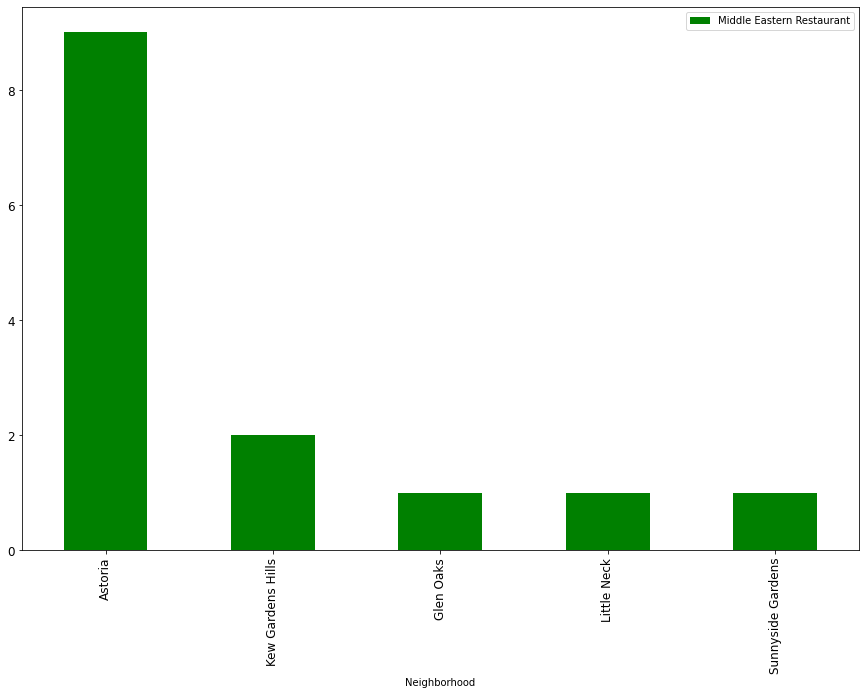

In [31]:
queens_grouped.loc[queens_grouped['Middle Eastern Restaurant'] > 0].sort_values(by=['Middle Eastern Restaurant'], ascending=False).plot(kind='bar',x='Neighborhood',y='Middle Eastern Restaurant', figsize=(15, 10), color='green', legend=True, fontsize=12)

<a id="item4" /> 

## 4. Cluster Neighborhoods

#### Clustering the Restaurants, Neighborhoods Data using silhouette method

For n_clusters = 2, silhouette score is 0.9717099567099564)
For n_clusters = 3, silhouette score is 0.9675324675324677)
For n_clusters = 4, silhouette score is 0.974025974025974)
For n_clusters = 5, silhouette score is 0.974025974025974)


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 6, silhouette score is 0.974025974025974)


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 7, silhouette score is 0.974025974025974)


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 8, silhouette score is 0.974025974025974)


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


For n_clusters = 9, silhouette score is 0.974025974025974)
For n_clusters = 10, silhouette score is 0.974025974025974)


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1105: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


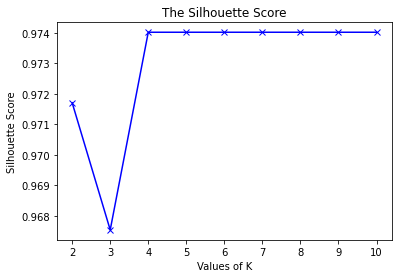

In [32]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt

min_clusters = 2
max_clusters = 11
K = range(min_clusters, max_clusters) 
s_scores = [] 

for n_clusters in K:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(queens_grouped_clustering)
    centers = clusterer.cluster_centers_
    score = silhouette_score(queens_grouped_clustering, preds)
    s_scores.append(score)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    
plt.plot(K, s_scores, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Silhouette Score') 
plt.title('The Silhouette Score') 
plt.show() 

Run _k_-means to cluster the neighborhoods


In [33]:
# set number of clusters
kclusters = s_scores.index(max(s_scores)) + min_clusters
#queens_grouped_clustering = queens_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(queens_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

## Let's create a new dataframe that includes the cluster as well as the top 2 venues for each neighborhood.


In [34]:
if not({'Cluster Labels'}.issubset(queens_grouped.columns)):
    queens_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

queens_merged = queens_data.dropna()

queens_merged = queens_merged.join(queens_grouped.dropna().set_index('Neighborhood'), on='Neighborhood')
queens_merged = q_neigh_restaurants_sorted[['Neighborhood','1st Most Common restaurant type','2nd Most Common restaurant type']].join(queens_grouped[['Neighborhood','Cluster Labels']].dropna().set_index('Neighborhood'), on='Neighborhood')
queens_merged = queens_merged.join(queens_data[['Neighborhood','Latitude','Longitude']].dropna().set_index('Neighborhood'), on='Neighborhood')
queens_merged = queens_merged.dropna()
queens_merged

,Neighborhood,1st Most Common restaurant type,2nd Most Common restaurant type,Cluster Labels,Latitude,Longitude
0,Arverne,Pizza Place,Burrito Place,0,40.589144,-73.791992
1,Astoria,Middle Eastern Restaurant,Deli / Bodega,1,40.768509,-73.915654
2,Astoria Heights,Deli / Bodega,Italian Restaurant,0,40.770317,-73.894680
3,Auburndale,Deli / Bodega,American Restaurant,0,40.761730,-73.791762
4,Bay Terrace,Pizza Place,Donut Shop,0,40.782843,-73.776802
5,Bayside,Pizza Place,Chinese Restaurant,0,40.766041,-73.774274
6,Beechhurst,Chinese Restaurant,Deli / Bodega,0,40.792781,-73.804365
7,Bellaire,Chinese Restaurant,Deli / Bodega,0,40.733014,-73.738892
8,Belle Harbor,Deli / Bodega,Bagel Shop,0,40.576156,-73.854018
9,Bellerose,Deli / Bodega,Pizza Place,0,40.728573,-73.720128


Finally, let's visualize the resulting clusters


In [41]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(queens_merged['Latitude'], queens_merged['Longitude'], queens_merged['Neighborhood'], queens_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

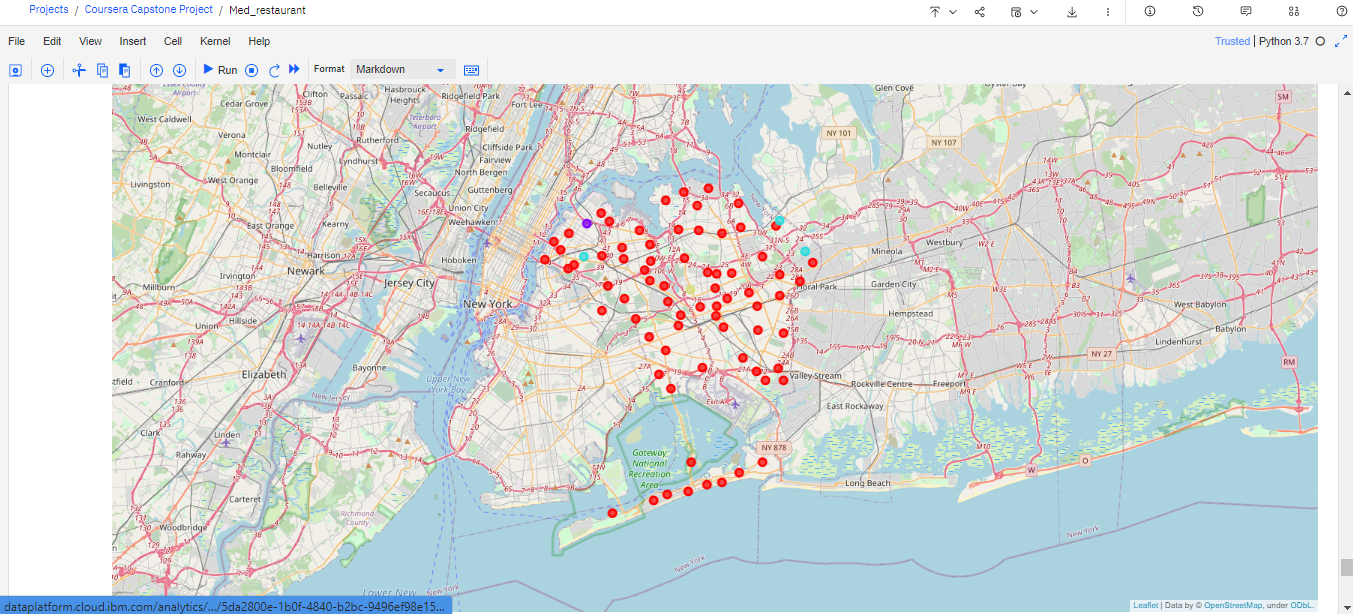

<a id='item5'></a>


## 5. Examine Clusters


Now, we can examine each cluster and determine what distinguishes each cluster. 



#### Cluster 0
This Cluster seem to include the Queens neighborhoods with no Middle Eastern restaurants in them. Having zero competition will be a plus point to open a Middle Eastern restaurant there. These are the neighborhoods marked in red on the map.

As I will mention later in my report the Middle Eastern cuisine is a new trend targeting not only the consumers from a Middle Eastern background but various consumers looking for new cuisines and healthy alternatives.

In [36]:
#queens_grouped.loc[queens_grouped['Cluster Labels'] == 0, queens_grouped.columns[[0,1,64]]].sort_values(by=['Neighborhood'], ascending=True).set_index('Neighborhood')
x=queens_grouped.loc[queens_grouped['Cluster Labels'] == 0].sort_values(by=['Neighborhood'], ascending=True).set_index('Neighborhood')
#queens_grouped.loc[queens_grouped['Cluster Labels'] == 0].sort_values(by=['Neighborhood'], ascending=True).set_index('Neighborhood')
print(str(x.shape[0]) + ' neighborhoods have a prominent chance to be the location of the new Middle Eastern restaurant' )

72 neighborhoods have a prominent chance to be the location of the new Middle Eastern restaurant


#### Cluster 1
This Cluster seem to include just one of Queens neighborhoods with the most Middle Eastern restaurants, which is logical as Astoria is famous by being called 'Little Egypt'. Having lots competition will be a detering factor to open a restaurant there. Astoria is marked in purple on the map.


In [37]:
#queens_grouped.loc[queens_grouped['Cluster Labels'] == 1, queens_grouped.columns[[0,1,64]]].sort_values(by=['Neighborhood'], ascending=True).set_index('Neighborhood')
queens_grouped.loc[queens_grouped['Cluster Labels'] == 1].sort_values(by=['Neighborhood'], ascending=True).set_index('Neighborhood')

,Cluster Labels,Middle Eastern Restaurant
Neighborhood,,
Astoria,1,9


#### Cluster 2
This Cluster seem to include the Queens neighborhoods with the medium density of Middle Eastern restaurants. These are marked on the map in light blue.

In [38]:
#queens_grouped.loc[queens_grouped['Cluster Labels'] == 2, queens_grouped.columns[[0,1,64]]].sort_values(by=['Neighborhood'], ascending=True).set_index('Neighborhood')
queens_grouped.loc[queens_grouped['Cluster Labels'] == 2].sort_values(by=['Neighborhood'], ascending=True).set_index('Neighborhood')

,Cluster Labels,Middle Eastern Restaurant
Neighborhood,,
Glen Oaks,2,1
Little Neck,2,1
Sunnyside Gardens,2,1


#### Cluster 3
This is similar to Cluster 2 seem to include the Queens neighborhoods with the medium density of Middle Eastern restaurants. These are marked on the map in yellow.

In [39]:
#queens_grouped.loc[queens_grouped['Cluster Labels'] == 3, queens_grouped.columns[[0,1,64]]].sort_values(by=['Neighborhood'], ascending=True).set_index('Neighborhood')
queens_grouped.loc[queens_grouped['Cluster Labels'] == 3].sort_values(by=['Neighborhood'], ascending=True).set_index('Neighborhood')

,Cluster Labels,Middle Eastern Restaurant
Neighborhood,,
Kew Gardens Hills,3,2


### Conclusion
Flusing neighborhood is chosen because it's a neighborhood with lots of attractions pulling in consumers like CitiField, home of the New York Mets, Flushing Meadows Corona Park with New York Hall of Science and Queens Botanical Zoo. As shown in the graph below, Flushing restaurants categories are mostly Asian with no Middle Eastern restaurants competition, not even Mediterennean restaurants which might share the same consumers type as the Middle Eastern ones.

In [40]:
queens_sumx = queens_sum.loc[queens_sum['Neighborhood'] == 'Flushing'] 
zero_cols = [ col for col, is_zero in ((queens_sumx == 0).sum() == queens_sumx.shape[0]).items() if is_zero ]
queens_sumx.drop(zero_cols, axis=1, inplace=True)
queens_sumx.plot(kind='bar',figsize=(15, 10),legend=True, title='Flushing restaurants')
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)
plt.show()
plt.close()

NameError: name 'queens_sum' is not defined